In [1]:
"""Scripts for analyzing of phantom outputs.

This script generate lightcurves (LC) by doing radiative transfer on a grid.

"""

'Scripts for analyzing of phantom outputs.\n\nThis script generate lightcurves (LC) by doing radiative transfer on a grid.\n\n'

.

# Def

.

## Imports & Settings

In [2]:
import numpy as np
from numpy import pi
from astropy import units
from astropy import constants as const
import matplotlib.pyplot as plt
import matplotlib as mpl
from numba import jit
import sarracen
import itertools
from scipy import integrate, fft
from scipy.spatial import kdtree
from datetime import datetime
from moviepy.editor import ImageSequenceClip, concatenate_videoclips
#from os import path

In [3]:
# import my modules listed in ./main/

import clmuphantomlib as mupl
from clmuphantomlib            import MyPhantomDataFrames, get_eos
from clmuphantomlib.log        import is_verbose, say
from clmuphantomlib.settings   import DEFAULT_SETTINGS as settings
from clmuphantomlib.units_util import get_val_in_unit, set_as_quantity #, get_units_field_name, get_units_cgs
from clmuphantomlib.readwrite  import json_dump, json_load
from clmuphantomlib.eos_mesa   import EoS_MESA_opacity
from clmuphantomlib.light      import get_optical_depth_by_ray_tracing_3D, get_photosphere_on_ray

from multiprocessing import cpu_count, Pool #Process, Queue
NPROCESSES = 1 if cpu_count() is None else max(cpu_count(), 1)

In [4]:
# settings
#
#   imported from script_input.py file


from script_LCGen__input import verbose, verbose_loop, interm_dir, output_dir, unitsOut, PHOTOSPHERE_TAU, JOB_PROFILES_DICT
from _sharedFuncs import mpdf_read

# remove temp flag
interm_dir = interm_dir.split('test_')[0]

unitsOutTxt = {  key  : unitsOut[key].to_string('latex_inline') for key in unitsOut.keys() }


# set metadata
with open("_metadata__input.json", 'r') as f:
    metadata = json_load(f)
metadata['Title'] = "Getting light curves by intergrating across a grid of rays"
metadata['Description'] = f"""Getting light curves by intergrating across a grid of rays with the same directions
for dump file data generated by phantom
"""


plt.rcParams.update({'font.size': 20})
if __name__ == '__main__' and is_verbose(verbose, 'note'):
    # remember to check if name is '__main__' if you wanna say anything
    #    so when you do multiprocessing the program doesn't freak out
    say('note', "script", verbose, f"Will use {NPROCESSES} processes for parallelization")


*   Note   :    script:
	Will use 8 processes for parallelization


In [5]:
from clmuphantomlib.log import say, is_verbose
from clmuphantomlib.geometry import get_dist2_between_2pt, get_closest_pt_on_line
from clmuphantomlib.sph_interp import get_sph_interp, get_h_from_rho, get_no_neigh, _get_sph_interp_phantom_np
from clmuphantomlib.units_util import set_as_quantity, set_as_quantity_temperature, get_units_field_name
from clmuphantomlib.eos_base import EoS_Base
from clmuphantomlib.light import integrate_along_ray_grid, integrate_along_ray_gridxy

#  import (general)
import numpy as np
import numba
from numba import jit, prange
import sarracen
from scipy.stats import linregress

from clmuphantomlib.geometry import get_dist2_from_pts_to_line, get_dist2_from_pt_to_line_nb, get_ray_unit_vec, get_rays_unit_vec

## Functions

In [6]:
# load from matin script

# backup-ed old codes
from script_LCGen import integrate_along_ray, integrate_error_along_ray
# test codes (alpha)
from script_LCGen import _integrate_along_ray_gridxy_sub_parallel_analysis_test
# actual code
from script_LCGen import _integrate_along_ray_gridxy_sub_parallel_analysis, _integrate_along_ray_gridxy_sub_parallel_err_ind
# integrations
from script_LCGen import integrate_along_ray_gridxy_ind, integrate_along_ray_gridxy_err_ind
# rays grid generation, plotting
from script_LCGen import get_xy_grids_of_rays, plot_imshow
# error estimation
from script_LCGen import get_sph_neighbours, get_sph_error

In [7]:
def plot_comb(
    comb : dict,
    mode : str,
    output_dir: str,
    job_nicknames: list[str] = None,
    xyzs_list    : list[str] = None,
    plot_title_dict = {},
    outfilename_noext: None|str = None,
    out_savename : None|str = None,
    no_xy_txt    : None|str = None,
    xlim: None|tuple[float, float] = None,
    ylim: None|tuple[float, float] = None,
    whatlog      : str ='loglog',
    out_exts     : list[str] = ['pdf', 'png'],
    xyzs_V_list  : list[str] = ['xyz', 'xzy', 'zyx'],
    txt_ylabel_dict: dict = {
        'LC'  : 'Luminosity',
        'Nres': '$N_\\mathrm{res}$',
        'Rph' : '$R_\\mathrm{{ph}}$',
        'Aph' : '$A_\\mathrm{{ph}}$',
    },
    txt_title_dict: None|dict = {
        'LC'  : 'Light curves',
        'Nres': 'Photospheric Resolution',
        'Rph' : 'Photospheric radius',
        'Aph' : 'Photospheric area',
    }
) -> tuple[mpl.figure.Figure, mpl.axes.Axes, list[str]]:
    """Plot the lightcurve-related stuff from comb (combined data) generated by the script.

    outfilename_noext, out_savename, no_xy_txt: str
        supply either outfilename_noext or both out_savename & no_xy_txt.

    out_exts: str


    Returns: fig, ax, outfilenames
    
    """

    # sanity check
    if mode not in txt_ylabel_dict.keys():
        raise NotImplementedError(f"{mode=} not yet implemented. Acceptable modes: {txt_ylabel_dict.keys()}")
    
    fig, ax = plt.subplots(figsize=(10, 8))
    which_func = {
        'linear'  : ax.plot,
        'plot'    : ax.plot,
        'semilogx': ax.semilogx,
        'semilogy': ax.semilogy,
        'loglog'  : ax.loglog,
    }
    
    _job_nicknames = comb.keys() if job_nicknames is None else job_nicknames
    for job_nickname in _job_nicknames:

        if mode in {'Rph'}:
            Axyz = [comb[job_nickname][xyzs_V]['areas'].value/pi for xyzs_V in xyzs_V_list]
            V_total = np.prod(Axyz, axis=0)**0.5 * comb[job_nickname][xyzs_V_list[0]]['areas'].unit**1.5
        else:
            V_total = None

        _xyzs_list = comb[job_nickname] if xyzs_list is None else xyzs_list
        for xyzs in _xyzs_list:
            
            x = comb[job_nickname][xyzs]['times']
            if   mode in {'LC'}:
                y = comb[job_nickname][xyzs]['lums']
            elif mode in {'Nres'}:
                y = comb[job_nickname][xyzs]['npt_at_ph_lb']
            elif mode in {'Rph'}:
                y = V_total / (comb[job_nickname][xyzs]['areas']/pi)
            elif mode in {'Aph'}:
                y = comb[job_nickname][xyzs]['areas']
            
            which_func[whatlog](x, y, '.-', label=f"{job_nickname}, +{xyzs[2]}")
            
    ax.legend()
    ax.set_xlabel(f"Time / {x.unit.to_string('latex_inline')}")
    # set y label (remove slash if unit is dimensionless)
    ylabel = f"{txt_ylabel_dict[mode]} / {y.unit.to_string('latex_inline')}" if y.unit.to_string() else f"{txt_ylabel_dict[mode]}"
    ax.set_ylabel(f"{ylabel}")
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    if outfilename_noext is None:
        outfilename_noext = f"{output_dir}{mode}_{out_savename}_{no_xy_txt}"
    elif output_dir is not None:
        outfilename_noext = f"{output_dir}{outfilename_noext}"
    
    # write pdf
    outfilenames = []
    for out_ext in out_exts:
        if out_ext == 'pdf':
            if job_nickname in plot_title_dict.keys():
                ax.set_title(plot_title_dict[job_nickname])
            else:
                ax.set_title('')
            outfilename = f"{outfilename_noext}.{out_ext}"
            fig.savefig(outfilename)
            if is_verbose(verbose, 'note'):
                say('note', None, verbose, f"Fig saved to {outfilename}.")
            outfilenames.append(outfilename)
        else:
            title_txt  = mode if txt_title_dict is None else txt_title_dict[mode]
            title_txt += f" ({no_xy_txt}"
            if len(job_nicknames) == 1 and job_nickname in plot_title_dict.keys():
                title_txt += f", {plot_title_dict[job_nickname]}"
            title_txt += ")"
            ax.set_title(title_txt)
            outfilename = f"{outfilename_noext}.{out_ext}"
            fig.savefig(outfilename)
            if is_verbose(verbose, 'note'):
                say('note', None, verbose, f"Fig saved to {outfilename}.")
            outfilenames.append(outfilename)

    return fig, ax, outfilenames

In [8]:
def plot_heat(
    no_xy: tuple[int, int],
    rays: units.Quantity|np.ndarray,
    data: units.Quantity|np.ndarray,
    job_profile  : dict= None,
    file_index   : int = -1,
    title_suffix : str ="",
    notes        : dict= None,
    data_label   : str ="",
    save_label   : str ="",
    xyzs         : str|list[str] = 'xyz',
    out_exts     : list[str] = ['pdf', 'png'],
    nlevel       : int = 100,
    levels       : None|list[float] = None,
    ticks        : None|int|list[float] = None,
    cbar_num_fmt : None|type(abs) = None,
    norm=None,
    cmap=None,
    output_dir:str|None=None,
    verbose = 3,
):
    """Plotting a heatmap (contourf) of 1D data located at rays

    cbar_num_fmt: function
        colorbar label format.
        e.g. lambda x, pos: f"{x:.2e}"
    
    """


    if not isinstance(data, units.Quantity):
        data = set_as_quantity(data, units.dimensionless_unscaled)

    if not isinstance(rays, units.Quantity):
        rays = set_as_quantity(rays, units.dimensionless_unscaled)

    if job_profile is None:
        job_profile = {
            'plot_title_suffix': '',
            'nickname'         : '',
        }

    Xs = rays[:, 0, 0]
    Ys = rays[:, 0, 1]
    rays_val = rays.reshape(*no_xy, *rays.shape[1:]).value
    extent = (
        rays_val[ 0, 0, 0, 0] - (rays_val[ 1, 0, 0, 0] - rays_val[ 0, 0, 0, 0])/2,
        rays_val[-1,-1, 0, 0] + (rays_val[-1,-1, 0, 0] - rays_val[-2,-1, 0, 0])/2,
        rays_val[ 0, 0, 0, 1] - (rays_val[ 0, 1, 0, 1] - rays_val[ 0, 0, 0, 1])/2,
        rays_val[-1,-1, 0, 1] + (rays_val[-1,-1, 0, 1] - rays_val[-1,-2, 0, 1])/2,
    )
    xylim  = max([abs(it) for it in extent])
    xylims = (-xylim, xylim)
    levels = nlevel if not isinstance(norm, mpl.colors.Normalize) else np.linspace(norm.vmin, norm.vmax, nlevel+1)
    if isinstance(norm, mpl.colors.Normalize):
        levels = np.linspace(norm.vmin, norm.vmax, nlevel+1) if levels is None else levels
        if isinstance(ticks, int):
            ticks  = np.linspace(norm.vmin, norm.vmax, ticks+1)
    else:
        levels = nlevel if levels is None else levels
        

    fig, ax = plt.subplots(figsize=(10, 8))
    
    
    #cax = ax.imshow(data.reshape(no_xy).T.value, norm=norm, cmap=cmap, origin='lower', extent=extent)
    cax = ax.contourf(Xs.reshape(no_xy).value, Ys.reshape(no_xy).value, data.reshape(no_xy).value, levels, norm=norm, cmap=cmap)
    for c in cax.collections:
        c.set_edgecolor("face")
    cbar= fig.colorbar(cax, label=f"{data_label} / {data.unit.to_string('latex_inline')}", ticks=ticks, format=cbar_num_fmt)
    ax.set_xlabel(f"${xyzs[0]}$ / {rays.unit.to_string('latex_inline')}")
    ax.set_ylabel(f"${xyzs[1]}$ / {rays.unit.to_string('latex_inline')}")
    ax.set_xlim(xylims)
    ax.set_ylim(xylims)
    if notes is not None:
        ax.text(
            0.98, 0.98,
            f"Time = {notes['time']:.1f}\n" + \
            f" $L$ = {notes['lum' ]:.0f}",
            #color = "black",
            ha = 'right', va = 'top',
            transform=ax.transAxes,
        )

    no_xy_txt = 'x'.join([f'{i}' for i in no_xy])
    outfilename_noext = f"{output_dir}heat_{job_profile['nickname']}_{file_index:05d}_{''.join(xyzs)}_{save_label}_{no_xy_txt}"
    outfilenames = []

    # write pdf
    for out_ext in out_exts:
        outfilename = f"{outfilename_noext}.{out_ext}"
        if out_ext == 'pdf':
            ax.set_title('')
        else:
            ax.set_title(f"Heatmap of {data_label}\n{job_profile['plot_title_suffix']}")
        fig.savefig(outfilename)
        outfilenames.append(outfilename)
        if is_verbose(verbose, 'note'):
            say('note', None, verbose, f"Fig saved to {outfilename}.")
        
    return fig, ax, outfilenames

## example
#fig, ax = plot_imshow(
#    no_xy, rays * units.Rsun, anses, data_label="$I$", save_label="I_xyz",
#    job_profile=job_profile, file_index=file_index, output_dir=output_dir)

## Testing - Timeit

In [9]:
# settings
output_dir = f'../fig/20240222_LCGen/'
job_nicknames = ['2md', '4md'] #['4md'] #
xyzs_list = None #['xyz', 'xzy'] #None
out_savename  = 'dusty' if len(job_nicknames) > 1 else job_nicknames[0]
do_plots = {
    'LC'  : {
        'do_this': True,
        'xlim'   : ( 0., 45.),
        'ylim'   : (1e4, 1e7),
        'whatlog': 'semilogy',
        },
    'Nres': {
        'do_this': True,
        'xlim'   : ( 0., 45.),
        'ylim'   : (1.0, 100.),
        'whatlog': 'semilogy',
        },
    'Rph' : {
        'do_this': True,
        'xlim'   : ( 0., 20.),
        'ylim'   : (1e0, 1e3),
        'whatlog': 'semilogy',
        },
    'Aph' : {
        'do_this': True,
        'xlim'   : ( 0., 20.),
        'ylim'   : (1e1, 1e6),
        'whatlog': 'semilogy',
        },
}
plot_title_dict = {
    '2md': '$1.7 M_\\odot$',
    '4md': '$3.7 M_\\odot$',
}

### Reading existing intermediate files (summary)

*   Note   :    run_code() ==> <module>() ==> hdf5_load():
	Reading from ../interm/lcgen.16x16.hdf5  (compress=False)
*   Note   :    run_code() ==> <module>() ==> hdf5_load():
	Reading from ../interm/lcgen.64x64.hdf5  (compress=False)
*   Note   :    run_code() ==> <module>() ==> hdf5_load():
	Reading from ../interm/lcgen.256x256.hdf5  (compress=False)
*   Note   :    run_code() ==> <module>() ==> plot_comb():
	Fig saved to ../fig/20240222_LCGen/LC_dusty_16x16.pdf.
*   Note   :    run_code() ==> <module>() ==> plot_comb():
	Fig saved to ../fig/20240222_LCGen/LC_dusty_16x16.png.
*   Note   :    run_code() ==> <module>() ==> plot_comb():
	Fig saved to ../fig/20240222_LCGen/Nres_dusty_16x16.pdf.
*   Note   :    run_code() ==> <module>() ==> plot_comb():
	Fig saved to ../fig/20240222_LCGen/Nres_dusty_16x16.png.
*   Note   :    run_code() ==> <module>() ==> plot_comb():
	Fig saved to ../fig/20240222_LCGen/Rph_dusty_16x16.pdf.
*   Note   :    run_code() ==> <module>() ==> plot_comb():
	Fig 

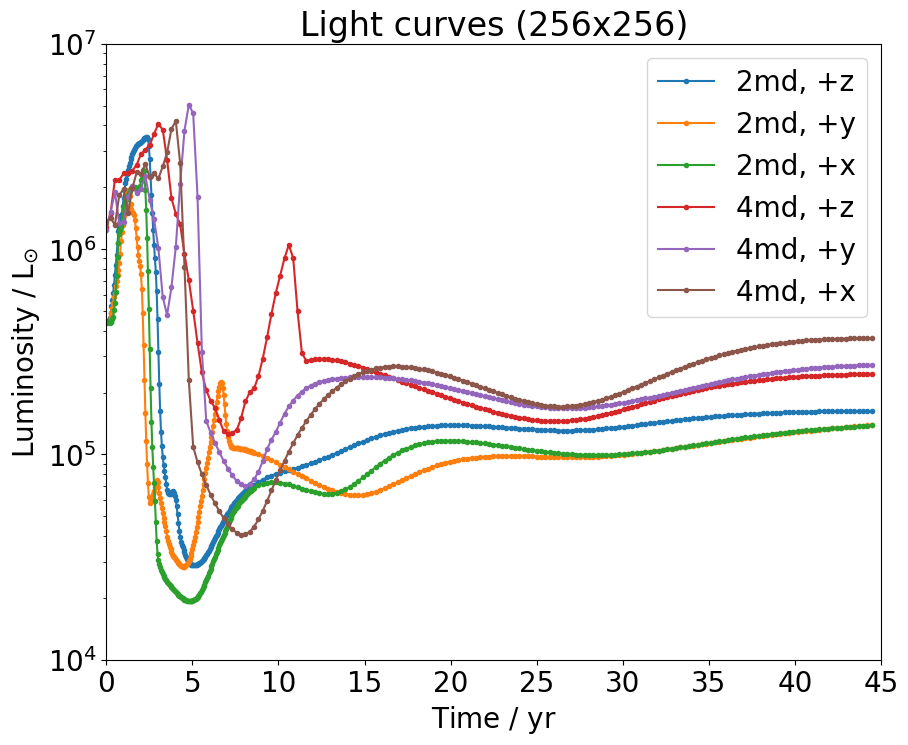

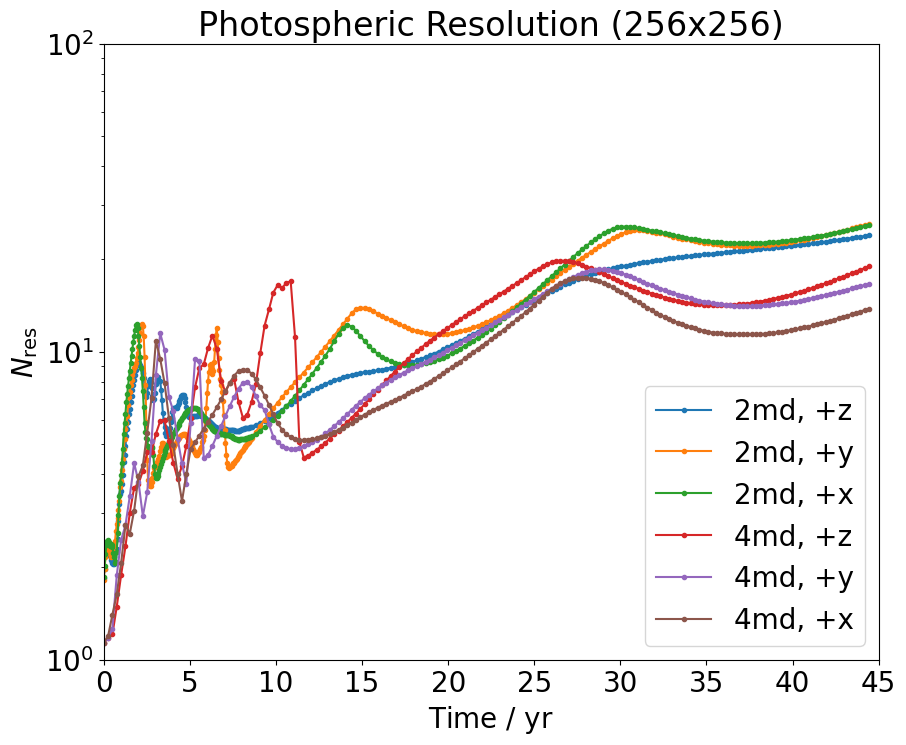

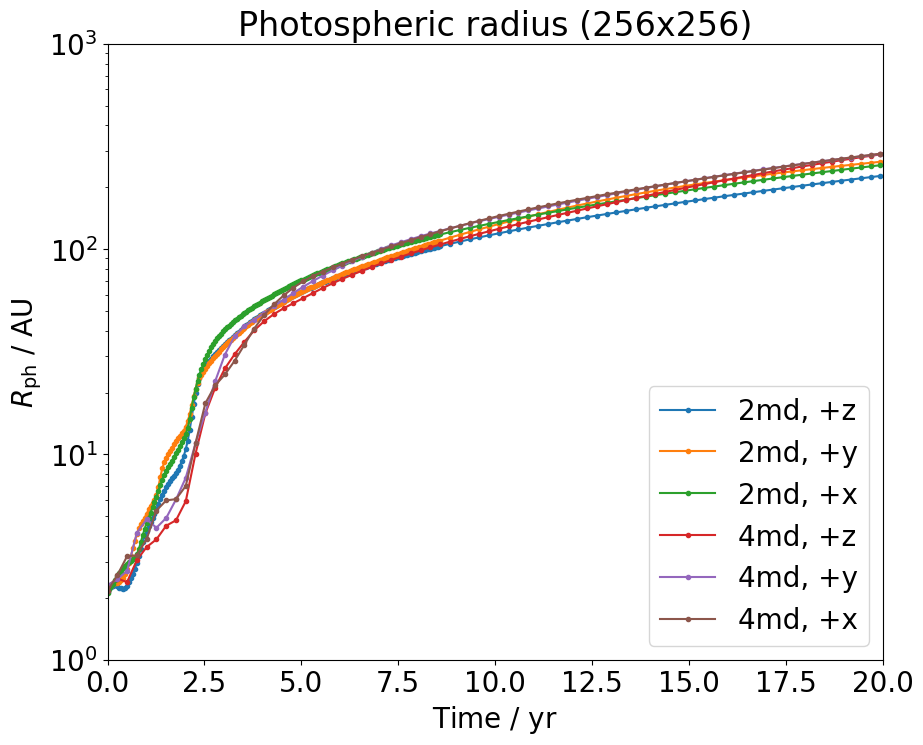

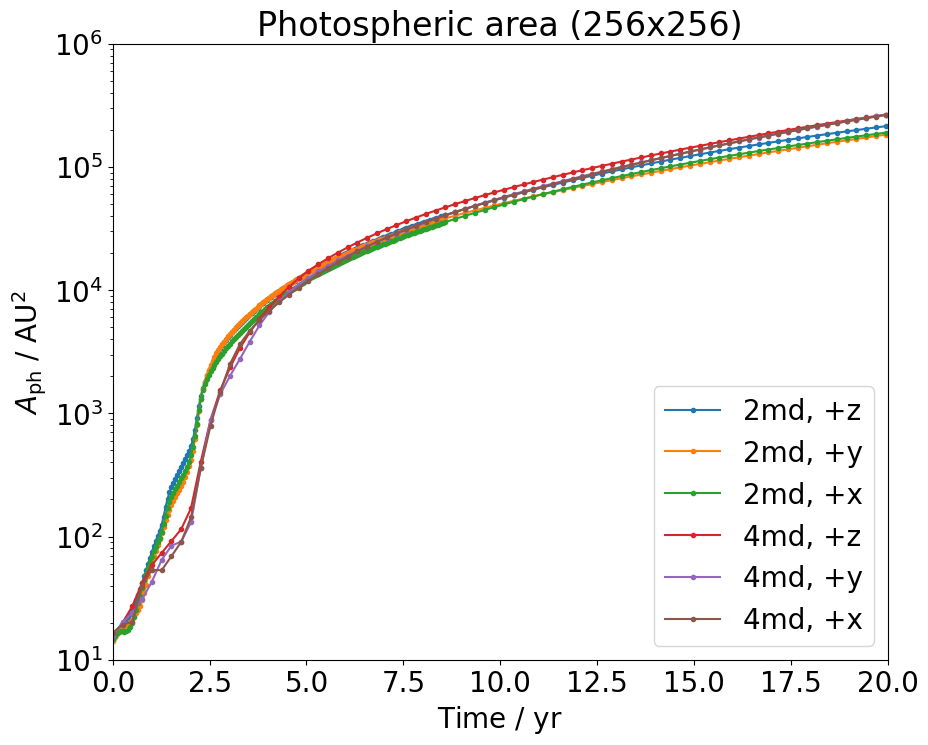

In [13]:
if __name__ == '__main__':
    combs = {}
    plt.close('all')
    
    for rays_res in [16, 64, 256]: #[16, 32, 64, 128, 256]:
        no_xy = (rays_res, rays_res)
        no_xy_txt = 'x'.join([f'{i}' for i in no_xy])
        combs[no_xy_txt] = mupl.hdf5_load(f"{interm_dir}lcgen.{no_xy_txt}.hdf5")
        #with open(f"{interm_dir}lcgen.{no_xy_txt}.json", 'r') as f:
        #    combs[no_xy_txt] = mupl.json_load(f)
    
    figs = []
    for no_xy_txt in combs.keys():
        comb = combs[no_xy_txt]

        for fig in figs:
            fig.clear()
            plt.close(fig)
        figs = []
        for mode in do_plots.keys():
            if do_plots[mode]['do_this']:
                fig, ax, outfilenames = plot_comb(
                    comb, mode, output_dir,
                    job_nicknames=job_nicknames,
                    xyzs_list=xyzs_list,
                    plot_title_dict=plot_title_dict,
                    out_savename=out_savename,
                    no_xy_txt=no_xy_txt,
                    xlim = do_plots[mode]['xlim'],
                    ylim = do_plots[mode]['ylim'],
                    whatlog = do_plots[mode]['whatlog'],
                )
                figs.append(fig)

In [14]:
# fitting photosphere expansion velocity
if __name__ == '__main__':
    for job_nickname, data0 in combs[no_xy_txt].items():
        for xyzs, data in data0.items():
            Rph   = (data['areas']/pi)**0.5
            times =  data['times']
            nstop = np.where(times > 5 * units.yr)[0][0]
            ans = linregress(times[nstop:], Rph[nstop:])
            print(
                job_nickname, xyzs, nstop,
                np.polyfit(np.log10(times.value)[nstop:], np.log10(Rph.value)[nstop:], 1),
                f"r-value={ans.rvalue:.5f}",
                f"v_r={(ans.slope * Rph.unit/times.unit).to(units.km/units.s):.2f}",
                f"+/- {(ans.stderr * Rph.unit/times.unit).to(units.km/units.s):.2f}",
            )

2m_2022 xyz 20 [0.99798097 0.5056446 ] r-value=0.97734 v_r=14.66 km / s +/- 0.51 km / s
2m_2022 xzy 20 [1.09507035 0.40190606] r-value=0.98708 v_r=15.71 km / s +/- 0.41 km / s
2m_2022 zyx 20 [1.08852836 0.40822787] r-value=0.98709 v_r=15.68 km / s +/- 0.41 km / s
2md xyz 100 [0.97167737 1.14781885] r-value=0.99972 v_r=58.76 km / s +/- 0.10 km / s
2md xzy 100 [0.96353131 1.14203819] r-value=0.99980 v_r=57.81 km / s +/- 0.08 km / s
2md zyx 100 [0.99033505 1.10260355] r-value=0.99998 v_r=57.66 km / s +/- 0.02 km / s
4m xyz 20 [ 1.67010321 -0.12429217] r-value=0.98720 v_r=26.25 km / s +/- 0.79 km / s
4m xzy 20 [ 1.77037362 -0.23701891] r-value=0.98765 v_r=26.41 km / s +/- 0.78 km / s
4m zyx 20 [ 1.77016566 -0.23533555] r-value=0.98630 v_r=26.58 km / s +/- 0.83 km / s
4md xyz 20 [1.03086679 1.12212975] r-value=0.99986 v_r=70.62 km / s +/- 0.10 km / s
4md xzy 20 [1.09023889 1.03947696] r-value=0.99949 v_r=73.70 km / s +/- 0.19 km / s
4md zyx 20 [1.08715309 1.04067402] r-value=0.99965 v_r=72.

### Reading existing intermediate files (individual dumps)

*   Note   :    run_code() ==> <module>() ==> hdf5_load():
	Reading from ../interm/4md_00000.lcgen.256x256.hdf5  (compress=False)
*   Note   :    run_code() ==> <module>() ==> hdf5_load():
	Reading from ../interm/4md_00100.lcgen.256x256.hdf5  (compress=False)
*   Note   :    run_code() ==> <module>() ==> hdf5_load():
	Reading from ../interm/4md_00200.lcgen.256x256.hdf5  (compress=False)
*   Note   :    run_code() ==> <module>() ==> hdf5_load():
	Reading from ../interm/4md_00300.lcgen.256x256.hdf5  (compress=False)
*   Note   :    run_code() ==> <module>() ==> hdf5_load():
	Reading from ../interm/4md_00400.lcgen.256x256.hdf5  (compress=False)
*   Note   :    run_code() ==> <module>() ==> hdf5_load():
	Reading from ../interm/4md_00500.lcgen.256x256.hdf5  (compress=False)
*   Note   :    run_code() ==> <module>() ==> hdf5_load():
	Reading from ../interm/4md_00600.lcgen.256x256.hdf5  (compress=False)
*   Note   :    run_code() ==> <module>() ==> hdf5_load():
	Reading from ../interm/4md_007

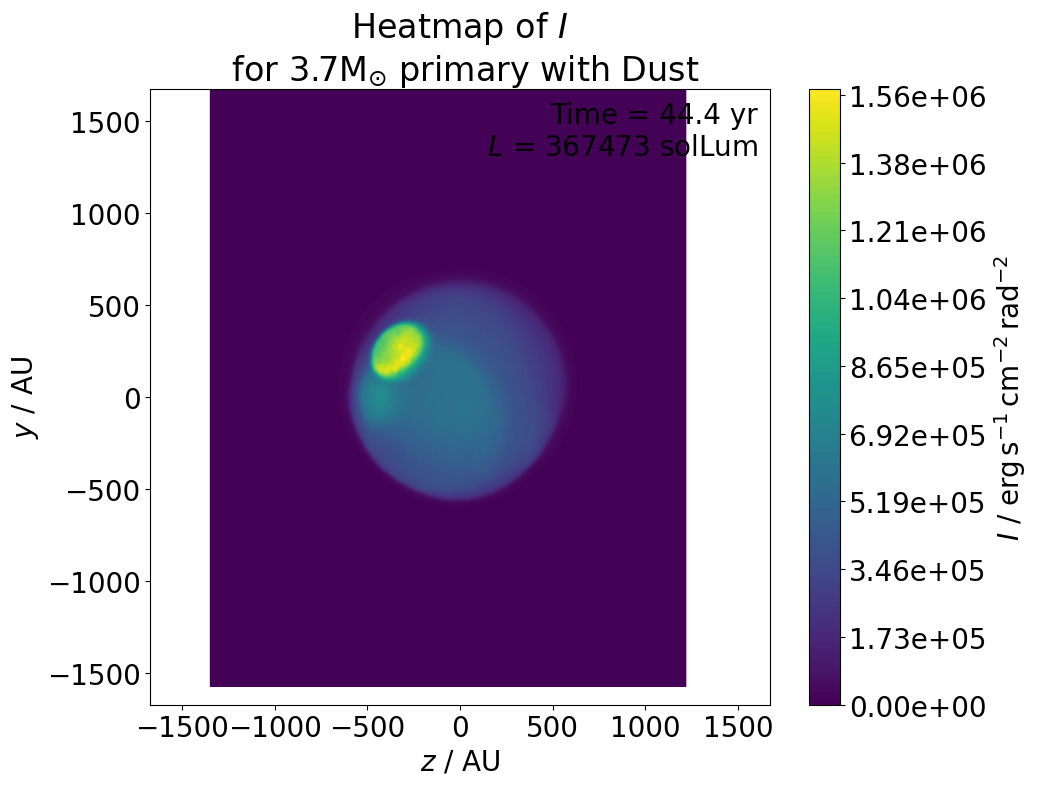

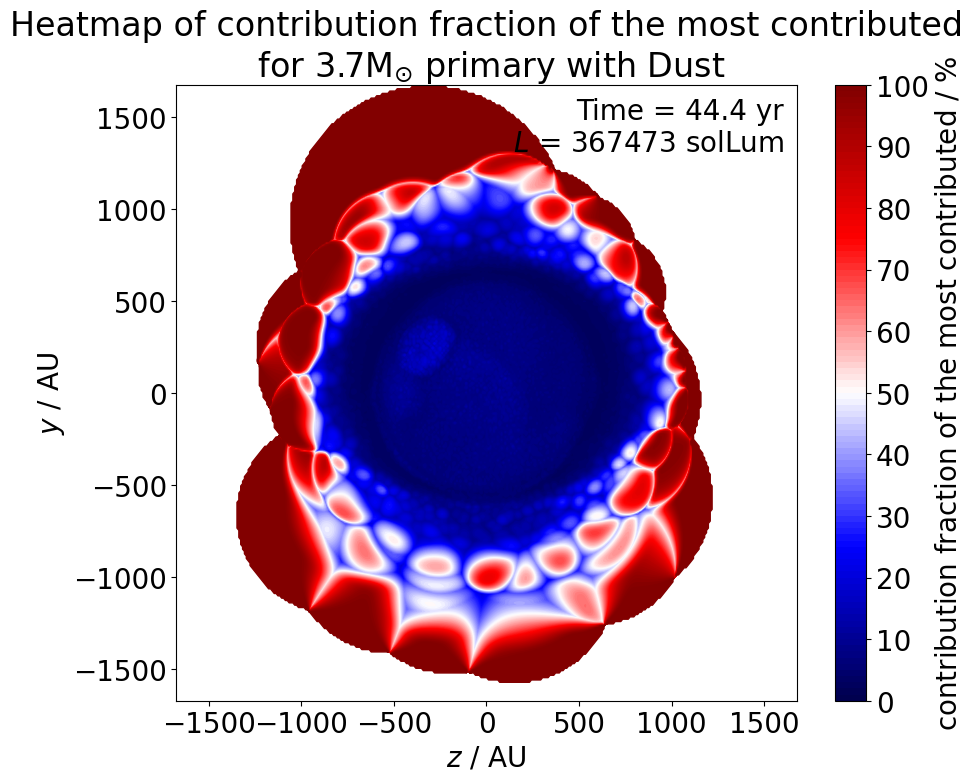

In [15]:
rays_res = 256
no_xy = (rays_res, rays_res)
no_xy_txt = 'x'.join([f'{i}' for i in no_xy])
output_dir = f'../fig/20240222_LCGen/{no_xy_txt}/'
unit_I = units.erg/units.cm**2/units.s/units.rad**2


if __name__ == '__main__':

    

    outfilenames_dict = {
        'rads' : {},
        'contr': {},
    }

    figs = []
    for job_nickname in job_nicknames[1:]:
        data = {}
        plt.close('all')

        job_profile = JOB_PROFILES_DICT[job_nickname]
        job_name    = job_profile['job_name']
        file_indexes= job_profile['file_indexes']

        for file_index in file_indexes[:]: #[0, 1200, 4800, 17600]: #
            plt.close('all')
            data_full = mupl.hdf5_load(f"{interm_dir}{job_nickname}_{file_index:05d}.lcgen.{no_xy_txt}.hdf5")
            xyzs_list = list(data_full.keys()).copy() if xyzs_list is None else xyzs_list
            
            # initialize
            for d in outfilenames_dict.keys():
                if job_nickname not in outfilenames_dict[d].keys():
                    outfilenames_dict[d][job_nickname] = {xyzs: [] for xyzs in xyzs_list}

            for xyzs in xyzs_list:
                data = data_full[xyzs]
                # fixing rads unit
                rads = data['rads'].to(unit_I)
                
                # reconstructing rays
                rays_u = np.zeros((data['rays'].shape[0], 2, 3)) * units.au
                rays_u[:, 0, :2] = data['rays']
                rays_u[:, 1, :2] = data['rays']
                rays_u[:, 1] += data['ray_unit_vec'] * units.au

                I_avg = (data['lum']/(4*pi*units.rad**2*data['area_one'])).to(unit_I)
                I_range = np.min((20., (rads.max()/I_avg).cgs.value,)) * I_avg.value # rads.max().to(unit_I).value #
                

                # plotting

                for fig in figs:
                    fig.clear()
                    plt.close(fig)
                    del fig
                del figs
                figs = []
                
                fig, _, outfilenames = plot_heat(
                    no_xy, rays_u, rads, data_label="$I$",
                    xyzs=xyzs, save_label=f"I",
                    job_profile=job_profile, file_index=file_index, notes=data,
                    norm=mpl.colors.Normalize(0., I_range),
                    cbar_num_fmt=lambda x, pos: f"{x:.2e}",
                    output_dir=output_dir, out_exts=['png'], verbose=verbose_loop)
                outfilenames_dict['rads' ][job_nickname][xyzs].append(outfilenames[-1])
                figs.append(fig)
                
                fig, _, outfilenames = plot_heat(
                    no_xy, rays_u, data['contr'], data_label="contribution fraction of the most contributed",
                    xyzs=xyzs, save_label=f"contr",
                    job_profile=job_profile, file_index=file_index, cmap='seismic', notes=data,
                    ticks=10,
                    norm=mpl.colors.Normalize(0., 100.),
                    output_dir=output_dir, out_exts=['png'], verbose=verbose_loop)
                outfilenames_dict['contr'][job_nickname][xyzs].append(outfilenames[-1])
                figs.append(fig)
                del data, rays_u, rads, I_avg, I_range
            del data_full

In [13]:
help(list([]).copy)

Help on built-in function copy:

copy() method of builtins.list instance
    Return a shallow copy of the list.



In [14]:
JOB_PROFILES_DICT['2md']['file_indexes'][258]

12300

In [18]:
outfilenames_dict

{'rads': {'2md': {'xyz': ['../fig/20240222_LCGen/256x256/heat_2md_00000_xyz_I_256x256.png',
    '../fig/20240222_LCGen/256x256/heat_2md_01200_xyz_I_256x256.png',
    '../fig/20240222_LCGen/256x256/heat_2md_04800_xyz_I_256x256.png',
    '../fig/20240222_LCGen/256x256/heat_2md_17600_xyz_I_256x256.png'],
   'xzy': ['../fig/20240222_LCGen/256x256/heat_2md_00000_xzy_I_256x256.png',
    '../fig/20240222_LCGen/256x256/heat_2md_01200_xzy_I_256x256.png',
    '../fig/20240222_LCGen/256x256/heat_2md_04800_xzy_I_256x256.png',
    '../fig/20240222_LCGen/256x256/heat_2md_17600_xzy_I_256x256.png'],
   'zyx': ['../fig/20240222_LCGen/256x256/heat_2md_00000_zyx_I_256x256.png',
    '../fig/20240222_LCGen/256x256/heat_2md_01200_zyx_I_256x256.png',
    '../fig/20240222_LCGen/256x256/heat_2md_04800_zyx_I_256x256.png',
    '../fig/20240222_LCGen/256x256/heat_2md_17600_zyx_I_256x256.png']},
  '4md': {'xyz': ['../fig/20240222_LCGen/256x256/heat_4md_00000_xyz_I_256x256.png',
    '../fig/20240222_LCGen/256x256/h

In [14]:
# generating movies (2md) (with 2 different fps speed)
if __name__ == '__main__':
    no_xy_txt = "256x256"
    job_nickname = '2md'
    for xyz in ['xyz', 'xzy', 'zyx']:
        input_dir = f'../fig/20240222_LCGen/{no_xy_txt}/'
        output_dir= f'../fig/20240222_LCGen/'
        for mode in ['I', 'contr']:
            fps1, outfilenames1 = 30, [f"{input_dir}heat_{job_nickname}_{i:05d}_{xyz}_{mode}_256x256.png" for i in range(   0,  3400-1,  20)]
            fps2, outfilenames2 =  6, [f"{input_dir}heat_{job_nickname}_{i:05d}_{xyz}_{mode}_256x256.png" for i in range(3400, 17600+1, 100)]
            moviefilename = f'{output_dir}heat_{job_nickname}__{xyz}_{mode}_{no_xy_txt}__movie.mp4'
            with ImageSequenceClip(outfilenames1, fps=fps1) as vid1, ImageSequenceClip(outfilenames2, fps=fps2) as vid2:
                concatenate_videoclips((vid1, vid2)).write_videofile(moviefilename)

Moviepy - Building video ../fig/20240222_LCGen/heat_2md__xyz_I_256x256__movie.mp4.
Moviepy - Writing video ../fig/20240222_LCGen/heat_2md__xyz_I_256x256__movie.mp4



Moviepy - Done !
Moviepy - video ready ../fig/20240222_LCGen/heat_2md__xyz_I_256x256__movie.mp4
Moviepy - Building video ../fig/20240222_LCGen/heat_2md__xyz_contr_256x256__movie.mp4.
Moviepy - Writing video ../fig/20240222_LCGen/heat_2md__xyz_contr_256x256__movie.mp4



Moviepy - Done !
Moviepy - video ready ../fig/20240222_LCGen/heat_2md__xyz_contr_256x256__movie.mp4
Moviepy - Building video ../fig/20240222_LCGen/heat_2md__xzy_I_256x256__movie.mp4.
Moviepy - Writing video ../fig/20240222_LCGen/heat_2md__xzy_I_256x256__movie.mp4



Moviepy - Done !
Moviepy - video ready ../fig/20240222_LCGen/heat_2md__xzy_I_256x256__movie.mp4
Moviepy - Building video ../fig/20240222_LCGen/heat_2md__xzy_contr_256x256__movie.mp4.
Moviepy - Writing video ../fig/20240222_LCGen/heat_2md__xzy_contr_256x256__movie.mp4



Moviepy - Done !
Moviepy - video ready ../fig/20240222_LCGen/heat_2md__xzy_contr_256x256__movie.mp4
Moviepy - Building video ../fig/20240222_LCGen/heat_2md__zyx_I_256x256__movie.mp4.
Moviepy - Writing video ../fig/20240222_LCGen/heat_2md__zyx_I_256x256__movie.mp4



Moviepy - Done !
Moviepy - video ready ../fig/20240222_LCGen/heat_2md__zyx_I_256x256__movie.mp4
Moviepy - Building video ../fig/20240222_LCGen/heat_2md__zyx_contr_256x256__movie.mp4.
Moviepy - Writing video ../fig/20240222_LCGen/heat_2md__zyx_contr_256x256__movie.mp4



Moviepy - Done !
Moviepy - video ready ../fig/20240222_LCGen/heat_2md__zyx_contr_256x256__movie.mp4


In [16]:
# generating movies (4md)
if __name__ == '__main__':
    no_xy_txt = "256x256"
    job_nickname = '4md'
    for xyz in ['xyz', 'xzy', 'zyx']:
        input_dir = f'../fig/20240222_LCGen/{no_xy_txt}/'
        output_dir= f'../fig/20240222_LCGen/'
        for mode in ['I', 'contr']:
            fps1, outfilenames1 =  6, [f"{input_dir}heat_{job_nickname}_{i:05d}_{xyz}_{mode}_256x256.png" for i in range(0, 17600+1, 100)]
            moviefilename = f'{output_dir}heat_{job_nickname}__{xyz}_{mode}_{no_xy_txt}__movie.mp4'
            with ImageSequenceClip(outfilenames1, fps=fps1) as vid1:
                vid1.write_videofile(moviefilename)

Moviepy - Building video ../fig/20240222_LCGen/heat_4md__xyz_I_256x256__movie.mp4.
Moviepy - Writing video ../fig/20240222_LCGen/heat_4md__xyz_I_256x256__movie.mp4



Moviepy - Done !
Moviepy - video ready ../fig/20240222_LCGen/heat_4md__xyz_I_256x256__movie.mp4
Moviepy - Building video ../fig/20240222_LCGen/heat_4md__xyz_contr_256x256__movie.mp4.
Moviepy - Writing video ../fig/20240222_LCGen/heat_4md__xyz_contr_256x256__movie.mp4



Moviepy - Done !
Moviepy - video ready ../fig/20240222_LCGen/heat_4md__xyz_contr_256x256__movie.mp4
Moviepy - Building video ../fig/20240222_LCGen/heat_4md__xzy_I_256x256__movie.mp4.
Moviepy - Writing video ../fig/20240222_LCGen/heat_4md__xzy_I_256x256__movie.mp4



Moviepy - Done !
Moviepy - video ready ../fig/20240222_LCGen/heat_4md__xzy_I_256x256__movie.mp4
Moviepy - Building video ../fig/20240222_LCGen/heat_4md__xzy_contr_256x256__movie.mp4.
Moviepy - Writing video ../fig/20240222_LCGen/heat_4md__xzy_contr_256x256__movie.mp4



Moviepy - Done !
Moviepy - video ready ../fig/20240222_LCGen/heat_4md__xzy_contr_256x256__movie.mp4
Moviepy - Building video ../fig/20240222_LCGen/heat_4md__zyx_I_256x256__movie.mp4.
Moviepy - Writing video ../fig/20240222_LCGen/heat_4md__zyx_I_256x256__movie.mp4



Moviepy - Done !
Moviepy - video ready ../fig/20240222_LCGen/heat_4md__zyx_I_256x256__movie.mp4
Moviepy - Building video ../fig/20240222_LCGen/heat_4md__zyx_contr_256x256__movie.mp4.
Moviepy - Writing video ../fig/20240222_LCGen/heat_4md__zyx_contr_256x256__movie.mp4



Moviepy - Done !
Moviepy - video ready ../fig/20240222_LCGen/heat_4md__zyx_contr_256x256__movie.mp4


### Timeit

In [ ]:
xyzs = 'yzx'
xyzs_names_list = [x for x in xyzs]
ans = integrate_along_ray_gridxy(sdf, srcfuncs, rays, xyzs_names_list=xyzs_names_list)
plt.close('all')
plt.imshow(ans.reshape(no_xy))
plt.savefig(f"{output_dir}/heat_I_{job_nickname}_{mpdf.file_index}_{xyzs}.png")
ans

In [ ]:
%timeit integrate_along_ray_grid(sdf, srcfuncs, rays, verbose=0)

In [ ]:
%timeit integrate_along_ray_gridxy(sdf, srcfuncs, rays, verbose=0)

In [ ]:
%timeit [integrate_along_ray(sdf, ray, srcfuncs)[4] for ray in rays]

### Analyzing error for tau

In [ ]:
# integrating for column kernel
kernel = sdf.kernel
ndim   = 3
q_xy   = 1.
w_col  = kernel.get_column_kernel_func(1000)

q_xy   = 0.

@jit(nopython=True, fastmath=True)
def get_q(*q_is):
    ans = 0
    for q_i in q_is:
        ans += q_i**2
    return ans**0.5


def get_w_q(q_z, q_xy, w, ndim):
    return kernel.w(get_q(q_xy, q_z), ndim)

def my_col(q_xy:float, kernel, ndim:int = 3):
    w = kernel.w
    w_rad = kernel.get_radius()
    return integrate.quad(lambda q_z: w(get_q(q_xy, q_z), ndim), -w_rad, w_rad)
    
#my_col(q_xy, kernel=kernel, ndim=ndim),  w_col(q_xy, ndim)

In [ ]:


def get_tau_for_single_particle(kappa_m_div_h2:float, q_xy:float, kernel, ndim:int = 3):
    w = kernel.w
    w_rad = kernel.get_radius()
    w_col = kernel.get_column_kernel_func(1000)

    return -np.log(integrate.quad(
        lambda q_z: np.exp(-kappa_m_div_h2 * integrate.quad(
            lambda q_z1: w(get_q(q_xy, q_z1), ndim),
            -w_rad, q_z
        )[0]) * w(get_q(q_xy, q_z), ndim),
        -w_rad, w_rad, 
    )[0] / w_col(q_xy, ndim))

kappa_m_div_h2, q_xy = 100., 1.5
dtau  = kappa_m_div_h2*w_col(q_xy, ndim)
w_col = kernel.get_column_kernel_func(1000)
term = 1-np.exp(-dtau)
tau = get_tau_for_single_particle(kappa_m_div_h2=kappa_m_div_h2, q_xy=q_xy, kernel=kernel, ndim=ndim)
print(f"{tau=}", f"{dtau=}", f"frac= {(tau/dtau)*100:.2f}%", '', sep='\n')
print(
    f"{np.exp(-tau    )*term=}",
    f"{np.exp(-tau    )*dtau=}",
    f"{np.exp(-0.     )*term=}",
    f"{np.exp(-dtau/2.)*term=}",
    f"{np.exp(-dtau   )*term=}",
    sep='\n')

In [ ]:
w_col

In [ ]:
kappa_m_div_h2 * integrate.quad(
            lambda q_z1: w(get_q(q_xy, q_z1), ndim),
            -2., 1.)[0]

In [ ]:
help(kernel.get_column_kernel_func)

### In Writing

#### Getting LC

In [ ]:
do_extrap : bool = False
T_cond_oxy: units.Quantity = 1450 * units.K
kappa_gas : units.Quantity = 2e-4*(units.cm**2/units.g)
job_name    = '../dustystar/clmu_dustybase/relax'#job_profile['job_name']
file_index  = 0
params      = JOB_PROFILES_DICT['2md']['params'] #job_profile['params']


mpdf = mupl.MyPhantomDataFrames()
mpdf.read(job_name, file_index, reset_xyz_by='CoM', calc_params=['vr', 'R1'], verbose=verbose)
sdf  = mpdf.data['gas']
eos = mupl.get_eos(ieos=10, params=params, settings=settings)
eos_opacity = EoS_MESA_opacity(params, settings)
sdf['T'] = eos.get_temp(rho=mpdf.get_val('rho'), u=mpdf.get_val('u')).to_value(mpdf.units['temp'])
del sdf['Tdust']
kappa_mesa = eos_opacity.get_kappa(mpdf.get_val('rho'), mpdf.get_val('T'), do_extrap=do_extrap)
#mpdf.data['gas']['kappa'] = np.where(
#    mpdf.data['gas']['T'] < T_cond_oxy,
#    kappa_gas.to_value( mpdf.units['opacity']),
#    kappa_mesa.to_value(mpdf.units['opacity']),
#)
mpdf.data['gas']['kappa'] = kappa_mesa.to_value(mpdf.units['opacity'])

In [ ]:
# testing ray loc distribution
rays, areas, dXs = get_xy_grids_of_rays(sdf, no_xy=(32, 32), frac_contained=100., use_adaptive_grid=False)
plt.plot(rays[:, 0, 0], rays[:, 0, 1], '.')

In [ ]:
hs = dats
hs

In [ ]:
#no_xy=(17, 17)
no_xy=(32, 32)
srcfuncs = np.array(mpdf.const['sigma_sb'] * sdf['T']**4) / pi #/ (4 * pi)
#srcfuncs = np.array(sdf['h'])


rays, areas, _ = get_xy_grids_of_rays(sdf, no_xy=no_xy, frac_contained=100., use_adaptive_grid=False)
dats = integrate_along_ray_grid(sdf, srcfuncs, rays, verbose=0)
lums = (4 * pi * dats * areas * mpdf.units['lum']).to(units.solLum)
lum  = lums.sum()
print(f"{lum:.2e}")
lum

In [ ]:
plt.hist(np.log10(mpdf.get_val('T').value))

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.loglog(np.sqrt(rays[:, 0, 0]**2+rays[:, 0, 1]**2), lums.to_value(units.Lsun) / areas, '.')
ax.set_xlabel('$R_\\mathrm{CoM}$ / Rsun')
ax.set_ylabel('$I \\, / \\, (4 \pi L_\\odot / R_\\odot^2)$')
#ax.set_ylabel('$\\triangle L$ / Lsun')
ax.set_title(f"Integrated specfic intensity contribution per ray\nbefore relaxation, resolution={mpdf.params['nparttot']:.2e}")
fig.savefig(f"../fig/scatter_dlum-vs-RCoM_relax_res{mpdf.params['nparttot']:.2e}.png")

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
s = ax.scatter(rays[:, 0, 0], rays[:, 0, 1], c=np.array(lums).reshape(no_xy))
fig.colorbar(s, label='')# {I / (4 \pi L_\\odot / R_\\odot^2)}$')
ax.set_xlabel('$x$ / Rsun')
ax.set_ylabel('$y$ / Rsun')
ax.set_title(f"Integrated  specfic intensity contribution per ray\nbefore relaxation, resolution={mpdf.params['nparttot']:.2e}")
fig.savefig(f"../fig/heat_dlum_relax_res{mpdf.params['nparttot']:.2e}.png")

.

#### Trying the same thing with after-relaxed higher resolution model

.

In [ ]:
job_nickname= '2md'
job_profile = JOB_PROFILES_DICT[job_nickname]
job_name    = job_profile['job_name']
params      = job_profile['params']
eos_opacity = EoS_MESA_opacity(params, settings)
mpdf = mpdf_read(job_name, 0, eos_opacity, reset_xyz_by='R1')
mpdf.calc_sdf_params(['R1'])
sdf  = mpdf.data['gas']
print(f"{mpdf.get_time() = }")

In [ ]:
mpdf.data['gas']['T'] = eos.get_temp(rho=mpdf.get_val('rho'), u=mpdf.get_val('u')).to_value(mpdf.units['temp'])
mpdf.data['gas'][['Tdust', 'temperature', 'T']]

In [ ]:
#no_xy=(17, 17)
no_xy=(32, 32)

srcfuncs = np.array(mpdf.const['sigma_sb'] * sdf['T']**4) / pi
rays, areas, _ = get_xy_grids_of_rays(sdf, no_xy=no_xy, frac_contained=100., use_adaptive_grid=False)
dats = integrate_along_ray_grid(sdf, srcfuncs, rays, verbose=0)
lums = (4 * pi * dats * areas * mpdf.units['lum']).to(units.solLum)
lum  = lums.sum()
print(f"{lum:.2e}")
lum

In [ ]:
srcfuncs = np.array(sdf['h'])
rays, areas, _ = get_xy_grids_of_rays(sdf, no_xy=no_xy, frac_contained=100., use_adaptive_grid=False)
hs   = integrate_along_ray_grid(sdf, srcfuncs, rays, verbose=0)
hs  *= units.Rsun
hs

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.loglog(np.sqrt(rays[:, 0, 0]**2+rays[:, 0, 1]**2), lums.value / areas, '.')
ax.set_xlabel('$R_\\mathrm{CoM}$ / Rsun')
ax.set_ylabel('$I \\, / \\, (4 \pi L_\\odot / R_\\odot^2)$')
ax.set_title(f"Integrated luminosity contribution per ray\nafter relaxation, resolution={mpdf.params['nparttot']:.2e}")
fig.savefig(f"../fig/scatter_dlum-vs-RCoM_light_res{mpdf.params['nparttot']:.2e}.png")

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
s = ax.scatter(rays[:, 0, 0], rays[:, 0, 1], c=(np.array(lums / areas).reshape(no_xy))) #np.log10
fig.colorbar(s, label='${I / (4 \pi L_\\odot / R_\\odot^2)}$') #\\log_{10} 
ax.set_xlabel('$x$ / Rsun')
ax.set_ylabel('$y$ / Lsun')
ax.set_title(f"Integrated specfic intensity contribution per ray\nafter relaxation, resolution={mpdf.params['nparttot']:.2e}")
fig.savefig(f"../fig/heat_dI_light_res{mpdf.params['nparttot']:.2e}.png")

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
#s = ax.scatter(rays[:, 0, 0], rays[:, 0, 1], c=(np.array(lums / areas).reshape(no_xy))) #np.log10
s = ax.imshow(np.array(lums / areas).reshape(no_xy), origin='lower')
fig.colorbar(s, label='${I / (4 \pi L_\\odot / R_\\odot^2)}$') #\\log_{10} 
#ax.set_xlabel('$x$')# / Rsun')
#ax.set_ylabel('$y$')# / Lsun')
ax.set_title(f"Integrated specfic intensity contribution per ray\nafter relaxation, resolution={mpdf.params['nparttot']:.2e}")
fig.savefig(f"../fig/heat_dI_light_res{mpdf.params['nparttot']:.2e}.png")

In [ ]:
plt.close('all')
fig, ax = plt.subplots(figsize=(10, 8))
#s = ax.scatter(rays[:, 0, 0], rays[:, 0, 1], c=(np.array(lums / areas).reshape(no_xy))) #np.log10
s = ax.imshow(np.array(hs).reshape(no_xy), origin='lower')
fig.colorbar(s, label='$h \\, / \\, R_\\odot$') #\\log_{10} 
#ax.set_xlabel('$x$ / Rsun')
#ax.set_ylabel('$y$ / Lsun')
ax.set_title(f"Integrated smoothing length per ray\nafter relaxation, resolution={mpdf.params['nparttot']:.2e}")
fig.savefig(f"../fig/heat_h_light_res{mpdf.params['nparttot']:.2e}.png")

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
s = ax.scatter(rays[:, 0, 0], rays[:, 0, 1], c=(np.array(hs).reshape(no_xy))) #np.log10
fig.colorbar(s, label='${h / R_\\odot}$') #\\log_{10} 
ax.set_xlabel('$x$ / Rsun')
ax.set_ylabel('$y$ / Lsun')
ax.set_title(f"Integrated specfic intensity contribution per ray\nafter relaxation, resolution={mpdf.params['nparttot']:.2e}")
fig.savefig(f"../fig/heat_h_light_res{mpdf.params['nparttot']:.2e}.png")

In [ ]:
help(ax.imshow)

In [ ]:
7534.8/10246.54

In [ ]:
f"{lum:.2e}"

In [ ]:
get_xy_grids_of_rays

In [ ]:
plt.imshow(np.array(lums).reshape(no_xy))

In [ ]:
np.max(mpdf.data['gas']['h'])

In [ ]:
mpdf.data['gas']['u']

## IGNORE BELOW
#### NOT YET FINISHED ADAPTING FROM THE OLD SCRIPTS

### Getting initial MESA profile vs relaxed phantom profile

In [90]:
def plot_stuff(stuff_dict: dict, x_name: str, y_name: str, mpdf, job_profile, xlim: tuple[float, float]=(1., 1.e3)):
    plt.close()
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.loglog(stuff_dict[x_name], stuff_dict[y_name], '.')
    ax.set_xlabel(f"{x_name} / {stuff_dict[x_name].unit.to_string('latex_inline')}")
    ax.set_ylabel(f"{y_name} / {stuff_dict[y_name].unit.to_string('latex_inline')}")
    ax.text(
        0.98, 0.98, f"Time = {mpdf.get_time()}",
        ha = 'right', va = 'top', transform=ax.transAxes,
    )
    ax.set_title(f"scatter plot of all particles\n{job_profile['plot_title_suffix']}")
    ax.set_xlim(xlim)
    return fig, ax

In [91]:
# Test
job_nickname= '2md'
job_profile = JOB_PROFILES_DICT[job_nickname]
job_name    = job_profile['job_name']
params      = job_profile['params']
eos_opacity = EoS_MESA_opacity(params, settings)
mpdf = mpdf_read(job_name, 0, eos_opacity, reset_xyz_by='R1')
mpdf.calc_sdf_params(['R1'])
sdf  = mpdf.data['gas']
ray = mupl.get_rays(mpdf.data['sink'][['x', 'y', 'z']].iloc[0], np.array([0., 0., 1.]))
srcfuncs = mpdf.const['sigma_sb'] * sdf['T']**4 #/ (4 * pi)

*   Note   :    <module>() ==> mpdf_read() ==> read():
	

	Reading filename='../photosphere/luis_2md/light_00000'


*   Note   :    mpdf_read() ==> read() ==> reset_xyz_by():
	Reseting Origin to R1 ([-1.43135206e+02  6.48807731e-03  5.43625638e-03])...
*   Note   :    mpdf_read() ==> read() ==> reset_xyz_by():
	CoM location is now [ 1.43135206e+02 -6.48807731e-03 -5.43625638e-03]
**  Warning:    <module>() ==> mpdf_read() ==> read():
	kappa column exists.
	We here assume kappa is in phantom units self.units['opacity']=Unit("udist2 / umass") 
	However in phantom kappa is assumed to be in cgs unit.
	If so, please CONVERT KAPPA MANNUALLY into PHANTOM units BEFORE proceeding, e.g.:
		mpdf.data['gas']['kappa'] = mupl.units_util.get_val_in_unit(
		mpdf.data['gas']['kappa'], units.cm**2/units.g, mpdf.units['opacity'])
    Note: Density column rho already exist in self.time = 0.0.


In [92]:
# reading mesa data
mesa_data = np.loadtxt(
    '../dustystar/AGB_th.data', skiprows=6,
    usecols=(2, 3, 4, 9, 10, 11, 12, 19),
    dtype=[
        ('log10_R1', np.double),
        ('log10_T', np.double),
        ('log10_rho', np.double),
        ('R1_cm', np.double),
        ('mass_g', np.double),
        ('temp', np.double),
        ('rho', np.double),
        ('lum', np.double)]
)
stuff_mesa = {
    'R1': (mesa_data['R1_cm'] * units.cm).to(units.Rsun),
    'T' : mesa_data['temp'] * units.K,
    'lum' : mesa_data['lum'] * units.Lsun,
    'rho' : mesa_data['rho'] * (units.g/units.cm**3)
}
del mesa_data 
stuff_mesa['L'    ] = (4 * pi * stuff_mesa['R1']**2 * (const.sigma_sb * stuff_mesa['T']**4)).to(units.Lsun)
stuff_mesa['kappa'] = eos_opacity.get_kappa(rho=stuff_mesa['rho'], T=stuff_mesa['T'])
#stuff_mesa['wtf'  ] = (4 * pi * stuff_mesa['R1']**2 * (const.sigma_sb * stuff_mesa['T'].value**2.5 * units.K**4)).to(units.Lsun)
# below should be one, but it is not. Not sure why
L_0 = stuff_mesa['lum'][0]
R_0 = stuff_mesa[ 'R1'][0]
stuff_mesa['factor'] = (stuff_mesa['R1'].cgs**2 * (
    R_0**(-2) - integrate.cumtrapz(
        (stuff_mesa['kappa'] * stuff_mesa['rho'] / stuff_mesa['R1']**2).cgs, stuff_mesa['R1'].cgs, initial=0
    )*units.cm**(-2))).cgs
stuff_mesa['wtf'  ]  = (integrate.cumtrapz(
        (stuff_mesa['kappa'] * stuff_mesa['rho'] / stuff_mesa['R1']**2)[::-1].cgs, stuff_mesa['R1'][::-1].cgs, initial=0
    )*units.cm**(-2))[::-1]
stuff_mesa['test' ]  = (stuff_mesa['R1'].cgs[0]**2 * (
    stuff_mesa['R1'].cgs**(-2) - integrate.cumtrapz(
        (stuff_mesa['kappa'] * stuff_mesa['rho'] / stuff_mesa['R1']**2).cgs, stuff_mesa['R1'].cgs, initial=0
    )*units.cm**(-2))).cgs

In [ ]:
stuff = {}
stuff['kappa'] = mpdf.get_val('kappa').cgs
stuff['R1'   ] = mpdf.get_val('R1').to(units.Rsun)
stuff['T'    ] = mpdf.get_val('T').to(units.K)
stuff['L'    ] = (4 * pi * stuff['R1']**2 * (const.sigma_sb * stuff['T']**4)).to(units.Lsun)
stuff['rho'  ] = mpdf.get_val('rho').cgs

In [ ]:
stuff_rad = stuff.copy()
stuff_rad_indices = ()

In [ ]:
plt.close('all')
for what in ['T', 'rho', 'kappa']:
    fig, ax = plot_stuff(stuff, 'R1', what, mpdf, {'plot_title_suffix' : job_nickname + " - phantom vs mesa"})
    ax.loglog(stuff_mesa['R1'], stuff_mesa[what], '.', label='mesa')
    ax.axvline(x=stuff_mesa['R1'][0].value, color='grey', linestyle='dashed')
    ax.legend(['phantom', 'mesa'], loc='lower left')
    fig.savefig(f"{output_dir}/phantom-vs-mesa_2md_{what}-R1.png")
    plt.show(fig)

In [ ]:
np.log(678e89)

In [ ]:
%timeit np.log(123e34) - 211.44922056441047

In [ ]:
%timeit 123e34 / np.exp(211.44922056441047)

In [ ]:
(450*units.au).to_value(mpdf.units['dist'])

In [ ]:
inds = (sdf['R1'] > (450*units.au).to_value(mpdf.units['dist']))
(np.sum(sdf[inds]['m'])*mpdf.units['mass']).to(units.Msun)

In [ ]:
# Test
job_nickname= '2md'
job_profile = JOB_PROFILES_DICT[job_nickname]
job_name    = job_profile['job_name']
params      = job_profile['params']
eos_opacity = EoS_MESA_opacity(params, settings)
mpdf = mpdf_read(job_name, 0, eos_opacity, reset_xyz_by='R1')
mpdf.calc_sdf_params(['R1'])
sdf  = mpdf.data['gas']
inds = (sdf['R1'] > (450*units.au).to_value(mpdf.units['dist']))
(np.sum(sdf[inds]['m'])*mpdf.units['mass']).to(units.Msun)

In [ ]:
mpdf.get_val('kappa').cgs

In [ ]:
stuff = {}
stuff['kappa'] = mpdf.get_val('kappa').cgs
stuff['R1'   ] = mpdf.get_val('R1').to(units.Rsun)
stuff['T'    ] = mpdf.get_val('T').to(units.K)
stuff['L'    ] = (4 * pi * stuff['R1']**2 * (const.sigma_sb * stuff['T']**4)).to(units.Lsun)
stuff['wtf'  ] = (4 * pi * stuff['R1']**2 * (const.sigma_sb * stuff['T'].value**2.5 * units.K**4)).to(units.Lsun)
stuff['rhokappa'] = mpdf.get_val('rho').cgs * mpdf.get_val('kappa').cgs
stuff['rhokappaR'] = mpdf.get_val('rho').cgs * mpdf.get_val('kappa').cgs * mpdf.get_val('R1').cgs

In [ ]:
np.max(stuff['rhokappaR'] / (stuff['rhokappaR'] - 2) - 1)

In [ ]:
np.min(stuff['rhokappaR'] )

In [ ]:
(stuff_mesa['kappa'] * stuff_mesa['rho'] / stuff_mesa['R1']**2).cgs

In [ ]:
(L_0 / R_0**2).cgs

In [ ]:
plt.plot(stuff_mesa['R1'], stuff_mesa['factor'])
plt.ylim(0., 2.)

In [ ]:
fig, ax = plot_stuff(stuff_mesa, 'R1', 'factor', mpdf, {'plot_title_suffix' : 'mesa profile'}, xlim=None)
fig.savefig(f"{output_dir}/temp.png")

In [ ]:
fig, ax = plot_stuff(stuff_mesa, 'R1', 'wtf', mpdf, {'plot_title_suffix' : 'mesa profile'}, xlim=None)
fig.savefig(f"{output_dir}/temp.png")

In [ ]:
fig, ax = plot_stuff(stuff_mesa, 'R1', 'lum', mpdf, {'plot_title_suffix' : 'mesa profile'}, xlim=None)
fig.savefig(f"{output_dir}/temp.png")

In [ ]:
stuff_mesa['T']

In [ ]:
eos_opacity.get_kappa(stuff_mesa)

In [ ]:
stuff_mesa['lum'][:10]

In [ ]:
stuff_mesa['L'][0], stuff_mesa['lum'][0]

In [ ]:
fig, ax = plot_stuff(stuff_mesa, 'R1', 'T', mpdf, {'plot_title_suffix' : 'mesa profile'}, xlim=None)
fig.savefig(f"{output_dir}/temp.png")

In [ ]:
fig, ax = plot_stuff(stuff_mesa, 'R1', 'L', mpdf, {'plot_title_suffix' : 'mesa profile'}, xlim=None)
fig.savefig(f"{output_dir}/temp.png")

In [ ]:
stuff_mesa['R1'][::100]

In [ ]:
# phantom plots

In [ ]:
fig, ax = plot_stuff(stuff, 'R1', 'rhokappa', mpdf, job_profile)
fig.savefig(f"{output_dir}/temp.png")

In [ ]:
fig, ax = plot_stuff(stuff, 'R1', 'kappa', mpdf, job_profile)
fig.savefig(f"{output_dir}/temp.png")

In [ ]:
fig, ax = plot_stuff(stuff, 'R1', 'T', mpdf, job_profile)
fig.savefig(f"{output_dir}/temp.png")

In [ ]:
fig, ax = plot_stuff(stuff, 'R1', 'L', mpdf, job_profile)
fig.savefig(f"{output_dir}/temp.png")

In [ ]:
mpdf.plot_render()

In [ ]:
rays, areas = get_xy_grids_of_rays(sdf, no_xy=(17, 17), frac_contained=99.99)
rays

In [ ]:
no_xy=(17, 17)
rays, areas = get_xy_grids_of_rays(sdf, no_xy=no_xy, frac_contained=99.99)
lums = []
for ray, area in zip(rays, areas):
    ans = integrate_along_ray(sdf, ray, srcfuncs)
    pts_order, pts_on_ray, dtaus_ordered, taus_ordered, dat, _, dat_bwd_inc = ans
    lums.append(dat * area) #* 4 * pi 
    if len(lums)%10 == 0:
        print(len(lums))

lums = (lums * mpdf.units['lum']).to(units.solLum)
lum = lums.sum()
lum

In [ ]:
# Test
job_nickname= '2md'
job_profile = JOB_PROFILES_DICT[job_nickname]
job_name    = job_profile['job_name']
params      = job_profile['params']
eos_opacity = EoS_MESA_opacity(params, settings)
mpdf = mpdf_read(job_name, 0, eos_opacity)
sdf  = mpdf.data['gas']
ray = mupl.get_rays(mpdf.data['sink'][['x', 'y', 'z']].iloc[0], np.array([0., 0., 1.]))
srcfuncs = mpdf.const['sigma_sb'] * sdf['T'] * sdf['T']**4 #/ (4 * pi)

In [ ]:
rays, areas = get_xy_grids_of_rays(sdf, no_xy=(17, 17))
lum = 0.
lums = []
i = 0
for ray, area in zip(rays, areas):
    ans = integrate_along_ray(sdf, ray, srcfuncs)
    pts_order, pts_on_ray, dtaus_ordered, taus_ordered, dat, _, dat_bwd_inc = ans
    lum += dat * area #* 4 * pi
    lums.append(dat*area)
    if i%50 == 0:
        print(i)
    i += 1

lum *= mpdf.units['lum']
lum.to(units.solLum)/1e6

In [ ]:
sdf['R0'] = (sdf['x']**2 + sdf['y']**2 + sdf['z']**2)**0.5
sdf['kappa_cgs'] = mupl.units_util.get_val_in_unit(sdf['kappa'], mpdf.units['opacity'], units.cm**2/units.g)
sdf.iloc[np.array(sdf['R0'] > 380)]

In [ ]:
mpdf.plot_render()

In [ ]:
rays, areas = get_xy_grids_of_rays(sdf, no_xy=(16, 16))
lum = 0.
i = 0
for ray, area in zip(rays, areas):
    ans = integrate_along_ray(sdf, ray, srcfuncs)
    pts_order, pts_on_ray, dtaus_ordered, taus_ordered, dat, _, dat_bwd_inc = ans
    lum += dat * area #* 4 * pi 
    if i%50 == 0:
        print(i)
    i += 1

lum *= mpdf.units['lum']
lum.to(units.solLum)

In [ ]:
ans = integrate_along_ray(sdf, ray, srcfuncs)
pts_order, pts_on_ray, dtaus_ordered, taus_ordered, dat, _, dat_bwd_inc = ans
dat

In [ ]:

np.where(dat_bwd_inc / dat > 1e-7), dat_bwd_inc.shape

In [ ]:
def get_ph_vals(
    vals_names: list,
    mpdf: MyPhantomDataFrames,
    eos: mupl.eos_base.EoS_Base,
    rays_unit_vecs : np.ndarray, # (no_ray, 3)-shaped
    verbose: int,
):
    sdf_all = mpdf.data['gas']
    hs = np.array(sdf_all['h'])
    pts = np.array(sdf_all[['x', 'y', 'z']])    # (npart, 3)-shaped array
    kernel_radius = sdf_all.kernel.get_radius()

    plane_orig_vec = np.array(mpdf.data['sink'][['x', 'y', 'z']].iloc[0])

    # random direction in the sphere
    #rays_unit_vecs = get_rand_rays_unit_vec(no_ray)
    no_ray = len(rays_unit_vecs)
    
    vals_dict = {
        'tau_dust': np.full(no_ray, np.nan),
        'inner_dust_shell_rad': np.full(no_ray, np.nan) * mpdf.units['dist'],
    }
    
    for iray, ray_unit_vec in enumerate(rays_unit_vecs):
        ray = np.array([
            plane_orig_vec,
            plane_orig_vec + ray_unit_vec,
        ])
        
        pts_on_ray = mupl.get_closest_pt_on_line(pts, ray)
        sdf_selected_indices = (np.sum((pts - pts_on_ray)**2, axis=-1) <= (kernel_radius * hs)**2)
        sdf = sdf_all.iloc[sdf_selected_indices]
        
        pts_on_ray, dtaus, pts_order = get_optical_depth_by_ray_tracing_3D(sdf, ray)
        photosphere, waypts_list = get_photosphere_on_ray(
            pts_on_ray, dtaus, pts_order, sdf, ray,
            calc_params = vals_names,
            eos = eos,
            sdf_units = mpdf.units,
            photosphere_tau = PHOTOSPHERE_TAU,
            return_as_quantity=True,
            verbose = 1 if is_verbose(verbose, 'err') else 0,
        )
        for val_name in vals_names:
            if iray == 0:
                # init
                vals_dict[val_name] = np.full((*photosphere[val_name].shape, no_ray), np.nan)
                if isinstance(photosphere[val_name], units.quantity.Quantity):
                    vals_dict[val_name] *= photosphere[val_name].unit
            # save value
            vals_dict[val_name][iray] = photosphere[val_name]
            
            kappa_tol = 1e-7*(units.cm**2/units.g)
            kappa_tol_val = kappa_tol.to_value(mpdf.units['opacity'])
            pts_waypts_t = np.sum((pts_on_ray - ray[0]) * ray_unit_vec, axis=-1) # the higher, the more on the pt2 side (observer)
            # find the furtherest dust-containing particle on the observer's side
            last_dust_part_ordered_indices = np.where(np.logical_and(
                pts_waypts_t[pts_order] > 0,    # condition 1: on the observer's side (i.e. don't be further than the sink)
                sdf.iloc[pts_order]['kappa_dust'] > kappa_tol_val,    # condition 2: dust-containing
            ))[0]
            if len(last_dust_part_ordered_indices):
                # found the dust shell!
                last_dust_part_ordered_ind = last_dust_part_ordered_indices[-1]
                vals_dict['tau_dust'][iray] = np.sum(dtaus[pts_order][:last_dust_part_ordered_ind])
                vals_dict['inner_dust_shell_rad'][iray] = mupl.set_as_quantity(
                    pts_waypts_t[pts_order][last_dust_part_ordered_ind], mpdf.units['dist'])
    vals_dict['cos_theta'] = rays_unit_vecs[:, 2]
    vals_dict['ray_unit_vec'] = rays_unit_vecs
    
    return vals_dict

In [ ]:
def get_photosphere_vals_rand_samples(
    job_nickname: str,
    file_index: int,
    no_ray: int,
    vals_names: list = ['R1', 'T'],
    cos_theta_sample_no: int|None = None,
    mpdf: MyPhantomDataFrames = None,
    verbose: int = 3,
) -> dict:
    
    job_profile = JOB_PROFILES_DICT[job_nickname]
    job_name    = job_profile['job_name']
    params      = job_profile['params']
    ieos = job_profile['ieos']
    eos  = get_eos(ieos, params, settings)
    eos_opacity = EoS_MESA_opacity(params, settings)
    
    mpdf = mpdf_read(
        job_name, file_index, eos_opacity, mpdf,
        kappa_gas = 2e-4*(units.cm**2/units.g) if file_index != 0 else 0.*(units.cm**2/units.g),
        verbose=verbose)

    if cos_theta_sample_no is None:

        rays_unit_vecs = get_rand_rays_unit_vec(no_ray)
        vals_dict = get_ph_vals(vals_names, mpdf, eos, rays_unit_vecs, verbose=verbose)
    
        if is_verbose(verbose, 'note'):
            say('note', f'{mpdf.get_filename()}', verbose,
                *[f'{val_name} = {np.average(vals_dict[val_name])} +/- {np.std(vals_dict[val_name])}' for val_name in vals_names]
            )
    else:
        # A fixed amount of rays per cos_theta interval will be generated
        #cos_theta_sample_no = 2
        ray_per_cos_theta = int(no_ray/cos_theta_sample_no)
        cos_theta_delta = 1. / cos_theta_sample_no
        cos_thetas = np.linspace(-1+cos_theta_delta, 1-cos_theta_delta, cos_theta_sample_no)
        vals_by_cos_thetas = []
    
        for i, cos_theta_mid in enumerate(cos_thetas):
            rays_unit_vecs = get_rand_rays_unit_vec(ray_per_cos_theta, cos_theta_mid, cos_theta_delta)
            vals_dict = get_ph_vals(vals_names, mpdf, eos, rays_unit_vecs, verbose=verbose)
            #vals_dict['cos_theta'] = rays_unit_vecs[:, 2]
            vals_by_cos_thetas.append(vals_dict)
        
            if is_verbose(verbose, 'note'):
                say('note', f'cos_theta_mid = {cos_theta_mid}', verbose,
                    *[f'{val_name} = {np.average(vals_dict[val_name])} +/- {np.std(vals_dict[val_name])}' for val_name in vals_names]
                )
        
        vals_dict = { key: np.concatenate([data[key] for data in vals_by_cos_thetas]) for key in vals_by_cos_thetas[0].keys()}

    return vals_dict

.

## Main

.


In [ ]:
if __name__ == '__main__':
    mpdf = MyPhantomDataFrames()
    for job_nickname in ['2md']:  # '2md', 
        for file_index in [4800, 6400]: # [0, 2000, 8000, 17600]
            vals_dict = get_photosphere_vals_rand_samples(
                job_nickname, file_index, no_ray, vals_names=['R1', 'T', 'rho', 'kappa', 'nneigh', 'vr'], cos_theta_sample_no=None, mpdf=mpdf)
            with open(f"{mpdf.get_filename()}__photosphere-vals.json", 'w') as f:
                json_dump(vals_dict, f, metadata)
    if is_verbose(verbose, 'note'):
        say('note', '__main__', verbose, f"\n\n\n*** All Done. ***\n\n\n")